In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output
import time

from sklearn.datasets import fetch_openml
from sklearn.datasets._openml import _get_data_description_by_id
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

###########################
import sys, threading
from time import sleep
try:
    import thread
except ImportError:
    import _thread as thread

def quit_function(fn_name):
    thread.interrupt_main() # raises KeyboardInterrupt

def exit_after(s):
    def outer(fn):
        def inner(*args, **kwargs):
            timer = threading.Timer(s, quit_function, args=[fn.__name__])
            timer.start()
            try:
                result = fn(*args, **kwargs)
            finally:
                timer.cancel()
            return result
        return inner
    return outer

def run_with_timeout(func, timeout, on_timeout):
    try:
        func = exit_after(timeout)(func)
        return func()
    except KeyboardInterrupt:
        return on_timeout()
###########################

def fit_and_evaluate_by_CV(model, X, y, cv=10, timeout=None):
  '''
  like sklearn.model_selection.cross_val_score,
  but also measures train accuracy and supports timeout
  returns (avg_train_accuracy, avg_test_accuracy) or (NaN, NaN)
  '''
  @exit_after(timeout)
  def inner():
    train_scores = []
    test_scores = []
    kfold = StratifiedKFold(n_splits=cv)
    for train_index, test_index in kfold.split(X, y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      model_copy = clone(model).fit(X_train, y_train)
      train_scores.append(model_copy.score(X_train, y_train))
      test_scores.append(model_copy.score(X_test, y_test))
    return np.mean(train_scores), np.mean(test_scores)
  try:
    return inner()
  except KeyboardInterrupt:
    return np.nan, np.nan

In [3]:
# dataset ids from OpenML

# https://www.openml.org/search?q=qualities.NumberOfInstances%3A100..10000%2520qualities.NumberOfFeatures%3Alt%3B5000&type=data
ids = [699, 676, 704, 709, 665, 666, 416, 1042, 23516, 23499, 1456, 1433, 1435, 1436, 1441, 1448, 1450, 1413, 1420, 23380, 23420, 4540, 4551, 4552, 4553, 4329, 4340, 1039, 1016, 1070, 1024, 1027, 1028, 1030, 1097, 1099, 1035, 1037, 688, 890, 1245, 1228, 1571, 1572, 1574, 1579, 1600, 1589, 191, 197, 206, 373, 374, 294, 298, 299, 473, 446, 482, 386, 434, 558, 560, 561, 562, 566, 567, 568, 570, 572, 573, 575, 576, 577, 578, 503, 505, 507, 509, 522, 524, 528, 529, 531, 533, 534, 536, 541, 543, 544, 545, 546, 547, 549, 511, 512, 513, 516, 492, 497, 315, 301, 308, 287, 327, 328, 394, 395, 430, 405, 42672, 42673, 42674, 42675, 42676, 42871, 42872, 42874, 42875, 42878, 42880, 42896, 42851, 42855, 42858, 42859, 42860, 42881, 42882, 42883, 42889, 42861, 42862, 42863, 42864, 42865, 42866, 42867, 42869, 42870, 42841, 42842, 42843, 42844, 42847, 42848, 42849, 42850, 42768, 42770, 42897, 42887, 42898, 42890, 42893, 42804, 42805, 42981, 42982, 42986, 42987, 42974, 42975, 42976, 42977, 42978, 42979, 42980, 42994, 42999, 43000, 43003, 43004, 43005, 43006, 43007, 43009, 42960, 42795, 42799, 42661, 42662, 42663, 42664, 42665, 42667, 42723, 42726, 42727, 42730, 42716, 42825, 42834, 42835, 42836, 42837, 42838, 42840, 42682, 42689, 42699, 42700, 41705, 41938, 41939, 42125, 712, 1029, 41702, 41703, 686, 689, 690, 695, 703, 672, 673, 678, 680, 42197, 42198, 42900, 43008, 42962, 652, 653, 654, 655, 656, 657, 658, 41465, 645, 646, 647, 648, 649, 650, 651, 42360, 579, 580, 581, 582, 583, 584, 41720, 41721, 41722, 41724, 41725, 41726, 1449, 41707, 41716, 41719, 41713, 40645, 40646, 40647, 40648, 40649, 40650, 40693, 40700, 40663, 40664, 40665, 40666, 40669, 40702, 40704, 40705, 40706, 40707, 40708, 40710, 40671, 40677, 40678, 40680, 40711, 40713, 40681, 40682, 40686, 40687, 40690, 40993, 40997, 40998, 40999, 41000, 41021, 41002, 41003, 41004, 41005, 41006, 41007, 40981, 41981, 41972, 41973, 41977, 41978, 41980, 41996, 41997, 41961, 41962, 41964, 41966, 41967, 41968, 41969, 41952, 41953, 41943, 41944, 41945, 41946, 41950, 42002, 42003, 42010, 41928, 40496, 40497, 40498, 40474, 40475, 40476, 40477, 40478, 41551, 41552, 41553, 41554, 41555, 41556, 41557, 41558, 41559, 41582, 41583, 41567, 41568, 42498, 42543, 42544, 42545, 42547, 42532, 42535, 42471, 42472, 42464, 42470, 42530, 40864, 40869, 40971, 40976, 40910, 40900, 40916, 41163, 41164, 41187, 41919, 41907, 42572, 42575, 42563, 42564, 42565, 42566, 42570, 42631, 42632, 42633, 42636, 42637, 42638, 42642, 42643, 42644, 42645, 42646, 42647, 42652, 42653, 42654, 42655, 42621, 42622, 42623, 42624, 42625, 42626, 42627, 42628, 42629, 42630, 42603, 42604, 42605, 42606, 42607, 42609, 42610, 42611, 42612, 42613, 42614, 42615, 42616, 42617, 42618, 42619, 42620, 40591, 40592, 40593, 40594, 40595, 40596, 40597, 40588, 40589, 40590, 40536, 40601, 41142, 41143, 41144, 41146, 41156, 41158, 41082, 41083, 41091, 42172, 42176, 42177, 42178, 42133, 42140, 42107, 42110, 42091, 42097, 42098, 42099, 42166, 42167, 42169, 42123, 42159, 42111, 42112, 42113, 41430, 42347, 42336, 42337, 42351, 42352, 42359, 42328, 41265, 41464, 41466, 41467, 41468, 41469, 41470, 41471, 41472, 41473, 41475, 41476, 41477, 41478, 41479, 41545, 41546, 41547, 41548, 41550, 41482, 41483, 41484, 41485, 41486, 41487, 41488, 41489, 41490, 41538, 41511, 41515, 41516, 41517, 41518, 41519, 41491, 41492, 41496, 41510, 42071, 42051, 42055, 42056, 42065, 42066, 42070, 42041, 42045, 42046, 42050, 42021, 42025, 42026, 42030, 42031, 42035, 42036, 42040, 42015, 42016, 42020, 42011, 42201, 42204, 42192, 42193, 42195, 42196, 42182, 42184, 42186, 42188, 42259, 42231, 42233, 42223, 42224, 42261, 41701, 41669, 41700, 42399, 42361, 42362, 42363, 42364, 42365, 42366, 42368, 42369, 42370, 42436, 42437, 42439, 42440, 42371, 42372, 42441, 42442, 42443, 42444, 42445, 42401, 585, 586, 587, 588, 589, 590, 591, 592, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 632, 633, 634, 635, 636, 637, 638, 619, 620, 621, 622, 623, 624, 625, 639, 640, 641, 642, 643, 644, 598, 599, 600, 601, 602, 603, 626, 627, 628, 629, 630, 631, 593, 594, 595, 596, 597, 41826, 41829, 41830, 41818, 41821, 41797, 41801, 41857, 41839, 41841, 41844, 41834, 41811, 41812, 41815, 41846, 41847, 41848, 41849, 41803, 43026, 42203, 42367, 519, 41897, 41894, 41864, 41866, 41867, 41868, 41882, 41872, 41874, 41875, 41858, 41863, 41750, 41753, 41754, 41756, 41760, 41764, 41765, 41766, 41737, 41740, 41744, 41746, 41730, 41731, 41733, 41783, 41784, 41785, 41788, 41790, 41791, 41769, 43028, 43029, 456, 471, 526, 535, 540, 550, 551, 555, 556, 557, 504, 506, 520, 521, 523, 494, 500, 501, 502, 663, 664, 670, 671, 42907, 42905, 42904, 42906, 784, 778, 779, 775, 773, 774, 783, 776, 782, 801, 811, 805, 806, 812, 803, 807, 808, 813, 954, 953, 952, 949, 947, 950, 951, 955, 1484, 1487, 1490, 1489, 1493, 1492, 1491, 1488, 1482, 475, 329, 336, 464, 444, 335, 334, 448, 333, 469, 873, 876, 877, 868, 871, 869, 870, 875, 934, 941, 937, 932, 933, 936, 943, 935, 931, 1047, 1045, 1050, 1049, 1054, 1056, 1048, 1548, 1549, 1555, 1551, 1552, 1554, 1553, 1556, 1547, 375, 337, 450, 718, 714, 694, 716, 679, 717, 715, 888, 880, 879, 886, 889, 878, 885, 884, 965, 970, 956, 971, 958, 973, 962, 969, 1447, 1453, 1444, 1451, 1443, 1446, 1452, 1442, 1515, 1520, 1519, 1527, 1523, 1524, 1528, 1525, 1526, 338, 745, 742, 748, 741, 746, 749, 744, 743, 747, 685, 719, 720, 724, 723, 725, 721, 726, 825, 828, 833, 832, 827, 830, 829, 826, 1100, 1071, 1075, 1121, 1115, 1167, 1073, 1514, 1512, 1513, 1506, 1511, 1510, 1508, 1507, 461, 732, 735, 728, 737, 733, 736, 740, 730, 818, 820, 819, 816, 824, 814, 915, 914, 909, 913, 910, 908, 912, 916, 911, 1022, 1026, 1020, 1013, 1021, 1025, 1014, 1501, 1494, 1500, 1504, 1497, 1498, 1496, 1499, 1495, 463, 753, 761, 756, 752, 750, 751, 762, 763, 754, 865, 851, 853, 866, 850, 855, 863, 860, 867, 1004, 1012, 1006, 995, 994, 996, 1005, 1011, 997, 1455, 1466, 1467, 1464, 1462, 1465, 1460, 1463, 1539, 1545, 1544, 1542, 1540, 1541, 1543, 1546, 1538, 4153, 3773, 3769, 3771, 3772, 3775, 3776, 3845, 3843, 3847, 3850, 3849, 3910, 3913, 4016, 4021, 4017, 4015, 4020, 4019, 4094, 4090, 4091, 4088, 377, 796, 788, 797, 794, 793, 795, 789, 792, 799, 902, 904, 896, 903, 900, 907, 906, 895, 978, 987, 983, 980, 979, 976, 974, 991, 1468, 1479, 1472, 1480, 1475, 1473, 458, 771, 767, 764, 765, 766, 769, 768, 770, 772, 834, 837, 847, 838, 841, 849, 845, 924, 921, 923, 920, 918, 922, 926, 917, 925, 1066, 1065, 1069, 1068, 1067, 1064, 1063, 1059, 1061, 1535, 1529, 1530, 1566, 1558, 1557, 1560, 1565, 1559, 42908, 42918, 43035, 43033, 42931, 42930, 42910, 42911, 42912, 42972, 42909, 43038, 42895, 42969, 42965, 42964, 42968, 42966, 42989, 42970, 42971, 42585, 43045, 43050, 43049, 43047, 43056, 43051, 40691, 43062, 43059, 43060, 43064, 43063, 42165, 4544, 422, 43071, 43070, 40945, 41514, 42438, 42608, 41976, 43076, 43075, 43077, 4531, 213, 207, 222, 224, 227, 210, 225, 223, 209, 204, 231, 194, 195, 8, 198, 189, 1412, 200, 199, 232, 203, 196, 230, 229, 4353, 4134, 6332, 2, 40670, 40701, 5, 7, 9, 13, 25, 27, 29, 40979, 40966, 40984, 40982, 40994, 40983, 40975, 35, 42, 38, 49, 51, 1485, 24, 15, 40499, 4538, 40978, 56, 401, 392, 389, 391, 300, 185, 171, 186, 488, 381, 757, 188, 57, 470, 474, 466, 452, 449, 454, 451, 738, 55, 455, 460, 382, 810, 897, 990, 989, 984, 986, 1041, 3110, 3113, 3115, 3195, 3196, 3193, 3282, 3281, 3279, 3286, 3278, 3283, 3373, 3375, 3378, 3372, 3462, 3470, 3468, 3465, 3555, 3553, 3556, 3560, 3779, 3783, 3780, 3778, 3785, 3857, 3855, 3851, 3859, 3852, 3949, 3943, 3950, 3947, 3942, 3945, 3944, 3992, 3993, 3987, 3991, 4102, 4103, 4100, 4096, 4101, 313, 312, 285, 316, 311, 3805, 3810, 3812, 3811, 3813, 3809, 3837, 3836, 3834, 3835, 3838, 3841, 3921, 3922, 3914, 3920, 3915, 3916, 3917, 4004, 3999, 4000, 3997, 4082, 4081, 4085, 4077, 4080, 4078, 4084, 4079, 46, 40, 44, 43, 37, 41, 36, 39, 3760, 3759, 3765, 3761, 3764, 3766, 3867, 3862, 3863, 3864, 3926, 3928, 3931, 4005, 4012, 4013, 4009, 4006, 4076, 4071, 4075, 183, 164, 187, 182, 181, 3724, 3735, 3732, 3725, 3734, 3727, 3733, 3731, 3730, 3817, 3821, 3823, 3814, 3819, 3820, 3897, 3899, 3900, 3902, 3901, 3904, 3898, 3979, 3978, 3982, 3981, 3980, 3985, 4061, 4062, 4064, 62, 54, 48, 59, 60, 53, 61, 3802, 3801, 3881, 3880, 3878, 3879, 3885, 3977, 3976, 3969, 3971, 3974, 3972, 4056, 4055, 4058, 4053, 4052, 4057, 4050, 4051, 12, 10, 3, 16, 14, 11, 20, 28, 23, 22, 30, 18, 3753, 3758, 3755, 3757, 3752, 3895, 3888, 3889, 3893, 3963, 3966, 3960, 3965, 3967, 3968, 4040, 4037, 4034, 4039, 4126, 4123, 4122, 4124, 3745, 3737, 3747, 3749, 3741, 3870, 3869, 3871, 3874, 3875, 3872, 3959, 3957, 3951, 4044, 4042, 4046, 4049, 4048, 4041, 4045, 4120, 4113, 4114, 4115, 4119, 3789, 3793, 3788, 3790, 3787, 3792, 3829, 3832, 3824, 3826, 3938, 3934, 3933, 4027, 4029, 4024, 4028, 4026, 4105, 4108, 4111, 378, 1116, 3203, 3198, 3201, 3199, 3197, 3202, 3205, 3290, 3291, 3292, 3294, 3288, 3293, 3381, 3388, 3383, 3380, 3474, 3471, 3476, 3472, 3475, 3561, 3564, 3569, 3565, 3563, 3567, 3568, 3644, 3650, 3645, 3649, 3647, 940, 961, 963, 957, 1038, 1023, 3104, 3106, 3105, 3103, 3101, 3180, 3187, 3179, 3184, 3181, 3185, 3183, 3182, 3270, 3275, 3277, 3361, 3360, 3363, 3368, 3364, 3461, 3456, 3457, 3459, 3455, 3545, 3547, 3551, 3640, 3637, 798, 3090, 3097, 3092, 3096, 3089, 3178, 3267, 3265, 3262, 3352, 3359, 3358, 3354, 3353, 3450, 3449, 3452, 3444, 3445, 3534, 3540, 3538, 3535, 3541, 3628, 3632, 3629, 3630, 3624, 3658, 3657, 3651, 3659, 3652, 3655, 3661, 3667, 3663, 3664, 3665, 3666, 3678, 3673, 3672, 3676, 3677, 3684, 3683, 3682, 3685, 3686, 3690, 3693, 3692, 3689, 3696, 3700, 3703, 3697, 3699, 3714, 3712, 3711, 3707, 3713, 3715, 3721, 3720, 3722, 831, 993, 1000, 999, 3053, 3061, 3054, 3059, 3143, 3149, 3145, 3233, 3234, 3239, 3328, 3330, 3441, 3440, 3439, 3526, 3533, 3529, 3527, 3530, 3531, 3525, 3614, 3609, 3611, 3612, 930, 1017, 1018, 1010, 3076, 3074, 3075, 3073, 3079, 3158, 3157, 3153, 3255, 3256, 3257, 3259, 3251, 3333, 3338, 3335, 3334, 3337, 3432, 3426, 3428, 3425, 3433, 3430, 3427, 3518, 3517, 3619, 3622, 3615, 3616, 3618, 786, 967, 966, 968, 3082, 3085, 3080, 3086, 3081, 3088, 3163, 3166, 3169, 3161, 3162, 3164, 3165, 3245, 3247, 3243, 3249, 3246, 3350, 3346, 3349, 3342, 3343, 3344, 3417, 3424, 3423, 3420, 3419, 3507, 3511, 3510, 3515, 3603, 3598, 3605, 3597, 3599, 3601, 3604, 840, 839, 844, 1008, 1002, 1007, 1003, 3067, 3064, 3063, 3068, 3069, 3062, 3070, 3141, 3140, 3136, 3138, 3139, 3134, 3142, 3230, 3229, 3231, 3224, 3316, 3323, 3315, 3318, 3410, 3413, 3414, 3415, 3412, 3498, 3503, 3500, 3504, 3505, 3589, 3588, 3596, 802, 852, 944, 939, 3045, 3052, 3047, 3044, 3046, 3048, 3050, 3133, 3131, 3126, 3127, 3132, 3125, 3129, 3221, 3215, 3217, 3220, 3222, 3311, 3305, 3312, 3306, 3307, 3308, 3309, 3399, 3398, 3403, 3401, 3406, 3402, 3490, 3493, 3495, 3489, 3492, 3497, 3581, 3585, 3584, 3583, 858, 854, 975, 982, 3043, 3121, 3118, 3119, 3117, 3209, 3210, 3212, 3207, 3213, 3297, 3302, 3300, 3298, 3301, 3296, 3397, 3396, 3394, 3393, 3484, 3485, 3488, 3486, 3480, 3482, 3574, 3570, 3578, 3575, 3571, 4074, 4038, 4008, 41145, 481, 31, 50, 307, 23381, 43085, 43080]

In [140]:
datasets_info = pd.DataFrame(columns=['id', 'name', 'version', 'examples', 'features', 'cat', 'classes', 'top class',
    'LR test', 'SVC test', 'GB test', 'RF test', 'LR train', 'SVC train', 'GB train', 'RF train'])
datasets_data = {}

for id in ids:
  time.sleep(0.1) #to be able to interrupt loop
  try:
    # fetch
    def fetch():
        #descr = _get_data_description_by_id(699, data_home=None)
        info = fetch_openml(data_id=id, version='active')
        name, version = info['details']['name'], info['details']['version']
        X_dtypes = info['data'].dtypes.tolist()
        y_dtype = info['target'].dtype
        X, y = fetch_openml(data_id=id, return_X_y=True, as_frame=False, version='active')
        return name, version, X, y, X_dtypes, y_dtype
    def fetch_on_timeout():
        raise Exception('fetch timeout')
    name, version, X, y, X_dtypes, y_dtype = run_with_timeout(func=fetch, timeout=30, on_timeout=fetch_on_timeout)
    
    # general check
    if X is None or y is None:
      raise Exception('data is None')
    if X.ndim != 2 or y.ndim != 1:
      raise Exception('wrong data ndims')
    if not isinstance(X, np.ndarray):
      X = X.toarray()
    if not isinstance(y, np.ndarray):
      y = y.toarray()
    
    # counts check
    if X.shape[0] < 100:
      raise Exception(f'too few examples: {X.shape[0]}')
    max_classes_allowed = 20
    classes_count = len(np.unique(y))
    if classes_count > max_classes_allowed:
      raise Exception(f'too many classes: {classes_count}')
    if np.issubdtype(y.dtype, np.number) and (y.min() < 0 \
            or y.max() > max_classes_allowed or (y.round() != y).any()):
      raise Exception(f'wrong target format, probably a regression task')
    y = LabelEncoder().fit_transform(y)
    class_counts = np.bincount(y)
    class_counts = class_counts[class_counts != 0]
    if class_counts.min() < 10:
      raise Exception(f'class has too few examples: {class_counts.min()}')
    
    # preprocess and one-hot encoding
    X = np.nan_to_num(X)
    column_mask = [False] * X.shape[1]
    one_hot_encoded_columns = []
    for i, dtype in enumerate(X_dtypes):
        if str(dtype) == 'category':
            one_hot_encoded_columns.append(OneHotEncoder(sparse=False, drop='if_binary').fit_transform(X[:, i:i+1]))
            column_mask[i] = True
    X = X[:, ~np.array(column_mask)]
    if X.shape[1] > 0:
        X = StandardScaler().fit_transform(X)
    X = np.concatenate([X] + one_hot_encoded_columns, axis=1)
    print(f'Converted {np.sum(column_mask)} categorical features, {len(column_mask)} features -> {X.shape[1]} features')
        
    # saving general info
    top_class_ratio = np.bincount(y).max()/len(y)
    ds_info = {
        'id': id,
        'name': name,
        'version': version,
        'examples': X.shape[0],
        'features': X.shape[1],
        'cat': np.sum(column_mask),
        'classes': len(np.unique(y)),
        'top class': f'{top_class_ratio*100:.1f}%'
    }
    display(ds_info)
    
    # training
    
    print('training LogisticRegression')
    train_score, test_score = run_with_timeout(
        func=lambda: fit_and_evaluate_by_CV(LogisticRegression(solver='liblinear'), X, y),
        timeout=10, on_timeout=lambda: (np.nan, np.nan)
    )
    ds_info['LR train'] = f'{(train_score-top_class_ratio)*100:+.1f}%'
    ds_info['LR test'] = f'{(test_score-top_class_ratio)*100:+.1f}%'
    
    print('training SVC')
    train_score, test_score = run_with_timeout(
        func=lambda: fit_and_evaluate_by_CV(SVC(), X, y),
        timeout=10, on_timeout=lambda: (np.nan, np.nan)
    )
    ds_info['SVC train'] = f'{(train_score-top_class_ratio)*100:+.1f}%'
    ds_info['SVC test'] = f'{(test_score-top_class_ratio)*100:+.1f}%'
    
    print('training GradientBoostingClassifier')
    train_score, test_score = run_with_timeout(
        func=lambda: fit_and_evaluate_by_CV(GradientBoostingClassifier(), X, y),
        timeout=10, on_timeout=lambda: (np.nan, np.nan)
    )
    ds_info['GB train'] = f'{(train_score-top_class_ratio)*100:+.1f}%'
    ds_info['GB test'] = f'{(test_score-top_class_ratio)*100:+.1f}%'
    
    print('training RandomForestClassifier')
    train_score, test_score = run_with_timeout(
        func=lambda: fit_and_evaluate_by_CV(RandomForestClassifier(), X, y),
        timeout=10, on_timeout=lambda: (np.nan, np.nan)
    )
    ds_info['RF train'] = f'{(train_score-top_class_ratio)*100:+.1f}%'
    ds_info['RF test'] = f'{(test_score-top_class_ratio)*100:+.1f}%'

    # saving
    datasets_info = datasets_info.append(ds_info, ignore_index=True)
    datasets_data[name] = (X, y)
    
    # displaying
    clear_output(wait=True)
    display(datasets_info)
  except Exception as e:
    print(f'ERROR for id {id}: {e}')
    pass

,id,name,version,examples,features,cat,classes,top class,LR test,SVC test,GB test,RF test,LR train,SVC train,GB train,RF train
0,1042,gina_prior,1,3468,784,0,2,50.8%,+nan%,+nan%,+nan%,+nan%,+nan%,+nan%,+nan%,+nan%
1,23499,breast-cancer-dropped-missing-attributes-values,1,277,38,9,2,70.8%,+2.2%,+4.3%,+1.8%,+3.2%,+8.3%,+13.4%,+19.5%,+27.3%
2,1441,KungChi3,1,123,39,0,2,87.0%,+0.8%,+0.9%,-0.8%,-2.4%,+6.9%,+7.3%,+13.0%,+13.0%
3,1448,KnuggetChase3,1,194,39,0,2,81.4%,-2.5%,+0.0%,+0.0%,-1.0%,+4.6%,+3.6%,+18.6%,+18.6%
4,1450,MindCave2,1,125,39,0,2,64.8%,+4.0%,+7.2%,+4.7%,+8.0%,+17.7%,+13.7%,+35.2%,+35.2%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,481,biomed,1,209,14,1,2,64.1%,+23.0%,+26.8%,+27.8%,+25.3%,+24.9%,+28.8%,+35.9%,+35.9%
572,31,credit-g,1,1000,59,13,2,70.0%,+5.1%,+6.1%,+5.7%,+6.5%,+8.7%,+17.5%,+20.3%,+30.0%
573,50,tic-tac-toe,1,958,27,9,2,65.3%,+32.2%,+27.9%,+25.2%,+26.5%,+33.0%,+33.9%,+33.4%,+34.7%
574,307,vowel,2,990,26,2,11,9.1%,+39.4%,+68.9%,+nan%,+64.1%,+62.3%,+89.5%,+nan%,+90.9%


ERROR for id 43085: 'NoneType' object has no attribute 'dtype'
ERROR for id 43080: 'NoneType' object has no attribute 'dtype'


In [142]:
import pickle

datasets_info.to_csv('datasets_not_processed.csv', index=False)
with open('datasets_not_processed.pickle', 'wb') as f:
    pickle.dump(datasets_data, f)

In [5]:
import pickle

datasets_info = pd.read_csv('datasets_not_processed.csv')
with open('datasets_not_processed.pickle', 'rb') as f:
    datasets_data = pickle.load(f)
datasets_info

,id,name,version,examples,features,cat,classes,top class,LR test,SVC test,GB test,RF test,LR train,SVC train,GB train,RF train
0,1042,gina_prior,1,3468,784,0,2,50.8%,+nan%,+nan%,+nan%,+nan%,+nan%,+nan%,+nan%,+nan%
1,23499,breast-cancer-dropped-missing-attributes-values,1,277,38,9,2,70.8%,+2.2%,+4.3%,+1.8%,+3.2%,+8.3%,+13.4%,+19.5%,+27.3%
2,1441,KungChi3,1,123,39,0,2,87.0%,+0.8%,+0.9%,-0.8%,-2.4%,+6.9%,+7.3%,+13.0%,+13.0%
3,1448,KnuggetChase3,1,194,39,0,2,81.4%,-2.5%,+0.0%,+0.0%,-1.0%,+4.6%,+3.6%,+18.6%,+18.6%
4,1450,MindCave2,1,125,39,0,2,64.8%,+4.0%,+7.2%,+4.7%,+8.0%,+17.7%,+13.7%,+35.2%,+35.2%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,481,biomed,1,209,14,1,2,64.1%,+23.0%,+26.8%,+27.8%,+25.3%,+24.9%,+28.8%,+35.9%,+35.9%
572,31,credit-g,1,1000,59,13,2,70.0%,+5.1%,+6.1%,+5.7%,+6.5%,+8.7%,+17.5%,+20.3%,+30.0%
573,50,tic-tac-toe,1,958,27,9,2,65.3%,+32.2%,+27.9%,+25.2%,+26.5%,+33.0%,+33.9%,+33.4%,+34.7%
574,307,vowel,2,990,26,2,11,9.1%,+39.4%,+68.9%,+nan%,+64.1%,+62.3%,+89.5%,+nan%,+90.9%


In [6]:
max_versions = dict(datasets_info.groupby('name')['version'].max())
is_last_version = [(max_versions[name] == version) for name, version in zip(datasets_info.name, datasets_info.version)]
datasets_info = datasets_info[is_last_version]
datasets_info

,id,name,version,examples,features,cat,classes,top class,LR test,SVC test,GB test,RF test,LR train,SVC train,GB train,RF train
0,1042,gina_prior,1,3468,784,0,2,50.8%,+nan%,+nan%,+nan%,+nan%,+nan%,+nan%,+nan%,+nan%
1,23499,breast-cancer-dropped-missing-attributes-values,1,277,38,9,2,70.8%,+2.2%,+4.3%,+1.8%,+3.2%,+8.3%,+13.4%,+19.5%,+27.3%
2,1441,KungChi3,1,123,39,0,2,87.0%,+0.8%,+0.9%,-0.8%,-2.4%,+6.9%,+7.3%,+13.0%,+13.0%
3,1448,KnuggetChase3,1,194,39,0,2,81.4%,-2.5%,+0.0%,+0.0%,-1.0%,+4.6%,+3.6%,+18.6%,+18.6%
4,1450,MindCave2,1,125,39,0,2,64.8%,+4.0%,+7.2%,+4.7%,+8.0%,+17.7%,+13.7%,+35.2%,+35.2%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,41145,philippine,1,5832,308,0,2,50.0%,+nan%,+nan%,+nan%,+nan%,+nan%,+nan%,+nan%,+nan%
571,481,biomed,1,209,14,1,2,64.1%,+23.0%,+26.8%,+27.8%,+25.3%,+24.9%,+28.8%,+35.9%,+35.9%
572,31,credit-g,1,1000,59,13,2,70.0%,+5.1%,+6.1%,+5.7%,+6.5%,+8.7%,+17.5%,+20.3%,+30.0%
573,50,tic-tac-toe,1,958,27,9,2,65.3%,+32.2%,+27.9%,+25.2%,+26.5%,+33.0%,+33.9%,+33.4%,+34.7%


In [7]:
pd.options.mode.chained_assignment = None
for column in ['top class', 'LR test', 'SVC test', 'GB test', 'RF test',
               'LR train', 'SVC train', 'GB train', 'RF train']:
    datasets_info[column] = datasets_info[column].str.strip('%').astype(float)
test_columns = ['LR test', 'SVC test', 'GB test', 'RF test']
train_columns = ['LR train', 'SVC train', 'GB train', 'RF train']
for column in test_columns:
    datasets_info = datasets_info[~datasets_info[column].isnull()]
datasets_info['min test gain'] = np.array([datasets_info[col] for col in test_columns]).min(axis=0)
datasets_info['avg test gain'] = np.array([datasets_info[col] for col in test_columns]).mean(axis=0)
datasets_info['max test gain'] = np.array([datasets_info[col] for col in test_columns]).max(axis=0)
datasets_info

,id,name,version,examples,features,cat,classes,top class,LR test,SVC test,GB test,RF test,LR train,SVC train,GB train,RF train,min test gain,avg test gain,max test gain
1,23499,breast-cancer-dropped-missing-attributes-values,1,277,38,9,2,70.8,2.2,4.3,1.8,3.2,8.3,13.4,19.5,27.3,1.8,2.875,4.3
2,1441,KungChi3,1,123,39,0,2,87.0,0.8,0.9,-0.8,-2.4,6.9,7.3,13.0,13.0,-2.4,-0.375,0.9
3,1448,KnuggetChase3,1,194,39,0,2,81.4,-2.5,0.0,0.0,-1.0,4.6,3.6,18.6,18.6,-2.5,-0.875,0.0
4,1450,MindCave2,1,125,39,0,2,64.8,4.0,7.2,4.7,8.0,17.7,13.7,35.2,35.2,4.0,5.975,8.0
5,1413,MyIris,1,150,4,0,3,33.3,57.3,63.3,62.0,62.7,58.0,64.1,66.7,66.7,57.3,61.325,63.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,982,heart-c,2,303,22,7,2,54.5,30.4,29.0,26.7,28.7,33.4,37.5,45.0,45.5,26.7,28.700,30.4
571,481,biomed,1,209,14,1,2,64.1,23.0,26.8,27.8,25.3,24.9,28.8,35.9,35.9,23.0,25.725,27.8
572,31,credit-g,1,1000,59,13,2,70.0,5.1,6.1,5.7,6.5,8.7,17.5,20.3,30.0,5.1,5.850,6.5
573,50,tic-tac-toe,1,958,27,9,2,65.3,32.2,27.9,25.2,26.5,33.0,33.9,33.4,34.7,25.2,27.950,32.2


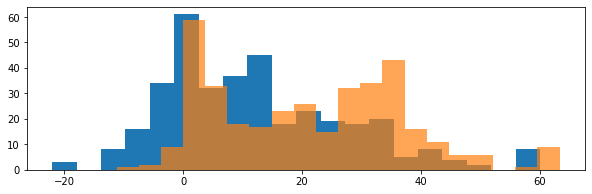

In [8]:
plt.figure(figsize=(10, 3))
plt.hist(datasets_info['min test gain'], bins=20)
plt.hist(datasets_info['max test gain'], bins=20, alpha=0.7)
plt.show()

In [9]:
too_high_accuracy = (datasets_info['top class'] + datasets_info['max test gain']) > 95
too_low_gain = datasets_info['max test gain'] < 10
too_small_difference = (datasets_info['max test gain'] - datasets_info['min test gain']) < 5
datasets_info = datasets_info[~too_high_accuracy & ~too_low_gain & ~too_small_difference]
datasets_info

,id,name,version,examples,features,cat,classes,top class,LR test,SVC test,GB test,RF test,LR train,SVC train,GB train,RF train,min test gain,avg test gain,max test gain
14,1228,nki70.arff,1,144,78,4,2,66.7,4.9,7.6,17.3,15.3,31.7,28.4,33.3,33.3,4.9,11.275,17.3
32,1029,LEV,1,1000,4,0,5,40.3,17.7,23.0,22.7,21.6,18.8,24.7,26.7,26.8,17.7,21.250,23.0
33,42900,breast-cancer-coimbra,1,116,9,0,2,55.2,11.9,11.6,19.8,15.1,24.7,33.2,44.8,44.8,11.6,14.600,19.8
36,40646,GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1,1,1600,60,20,2,50.0,-0.8,10.6,11.3,8.1,5.8,31.3,26.2,50.0,-0.8,7.300,11.3
37,40647,GAMETES_Epistasis_2-Way_20atts_0.4H_EDM-1_1,1,1600,56,20,2,50.0,-2.4,27.9,21.4,23.3,4.6,32.9,33.0,49.8,-2.4,17.550,27.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,1017,arrhythmia,2,452,279,73,2,54.2,17.9,22.8,29.6,28.8,37.6,34.0,45.5,45.8,17.9,24.775,29.6
556,839,kdd_el_nino-small,2,782,79,2,2,65.0,-9.5,9.8,16.9,14.4,29.5,31.3,34.4,35.0,-9.5,7.900,16.9
560,1007,bridges,5,107,76,8,2,58.9,27.8,23.3,20.6,22.4,35.4,35.4,41.1,41.1,20.6,23.525,27.8
564,944,echoMonths,2,130,9,3,2,50.8,26.2,21.5,16.9,22.3,29.8,34.0,49.2,49.2,16.9,21.725,26.2


In [26]:
#searching for similar names, leaving one in each set of similar names

dataset_names = datasets_info.name.tolist()

from collections import Counter
counter = Counter()
repetitions = []
for name in dataset_names:
    name_start = name[:5]
    repetitions.append(counter[name_start])
    counter[name_start] += 1
list(zip(repetitions, dataset_names))

[(0, 'nki70.arff'),
 (0, 'LEV'),
 (0, 'breast-cancer-coimbra'),
 (0, 'GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1'),
 (1, 'GAMETES_Epistasis_2-Way_20atts_0.4H_EDM-1_1'),
 (2, 'GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_50_EDM-2_001'),
 (3, 'GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_75_EDM-2_001'),
 (0, 'cars1'),
 (0, 'car-evaluation'),
 (0, 'parity5_plus_5'),
 (0, 'cleve'),
 (0, 'Touch2'),
 (0, 'newton_hema'),
 (0, 'fri_c1_500_25'),
 (1, 'fri_c2_100_25'),
 (2, 'fri_c3_100_10'),
 (3, 'fri_c0_250_5'),
 (0, 'chscase_funds'),
 (4, 'fri_c4_500_50'),
 (5, 'fri_c3_1000_50'),
 (6, 'fri_c1_100_25'),
 (7, 'fri_c3_1000_5'),
 (0, 'tae'),
 (0, 'parkinsons'),
 (0, 'analcatdata_boxing2'),
 (0, 'monks-problems-2'),
 (1, 'analcatdata_boxing1'),
 (8, 'fri_c3_250_50'),
 (9, 'fri_c1_100_50'),
 (10, 'fri_c2_250_50'),
 (11, 'fri_c2_500_10'),
 (12, 'fri_c1_500_5'),
 (13, 'fri_c3_500_50'),
 (14, 'fri_c4_100_50'),
 (15, 'fri_c4_250_25'),
 (16, 'fri_c3_500_10'),
 (17, 'fri_c1_250_10'),
 (0, 'autoUniv-au7

In [30]:
datasets_info = datasets_info[np.array(repetitions) == 0]
datasets_info

,id,name,version,examples,features,cat,classes,top class,LR test,SVC test,GB test,RF test,LR train,SVC train,GB train,RF train,min test gain,avg test gain,max test gain
14,1228,nki70.arff,1,144,78,4,2,66.7,4.9,7.6,17.3,15.3,31.7,28.4,33.3,33.3,4.9,11.275,17.3
32,1029,LEV,1,1000,4,0,5,40.3,17.7,23.0,22.7,21.6,18.8,24.7,26.7,26.8,17.7,21.250,23.0
33,42900,breast-cancer-coimbra,1,116,9,0,2,55.2,11.9,11.6,19.8,15.1,24.7,33.2,44.8,44.8,11.6,14.600,19.8
36,40646,GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1,1,1600,60,20,2,50.0,-0.8,10.6,11.3,8.1,5.8,31.3,26.2,50.0,-0.8,7.300,11.3
42,40700,cars1,1,392,11,1,3,62.5,14.0,13.8,24.7,24.7,15.9,17.0,37.5,37.5,13.8,19.300,24.7
44,40664,car-evaluation,1,1728,21,21,4,70.0,10.9,19.6,17.2,13.6,19.3,28.9,29.3,30.0,10.9,15.325,19.6
51,40706,parity5_plus_5,1,1124,10,10,2,50.4,-8.4,-21.1,-21.3,11.6,1.2,7.5,4.9,49.6,-21.3,-9.800,11.6
54,40710,cleve,1,303,27,8,2,54.5,33.0,29.4,26.7,27.7,33.0,38.3,44.9,45.5,26.7,29.200,33.0
99,42544,Touch2,1,265,10,0,8,17.7,51.3,59.3,54.4,63.0,60.1,69.0,82.3,82.3,51.3,57.000,63.0
145,784,newton_hema,2,140,13,1,2,50.0,14.3,17.9,11.4,10.0,32.9,34.5,49.4,50.0,10.0,13.400,17.9


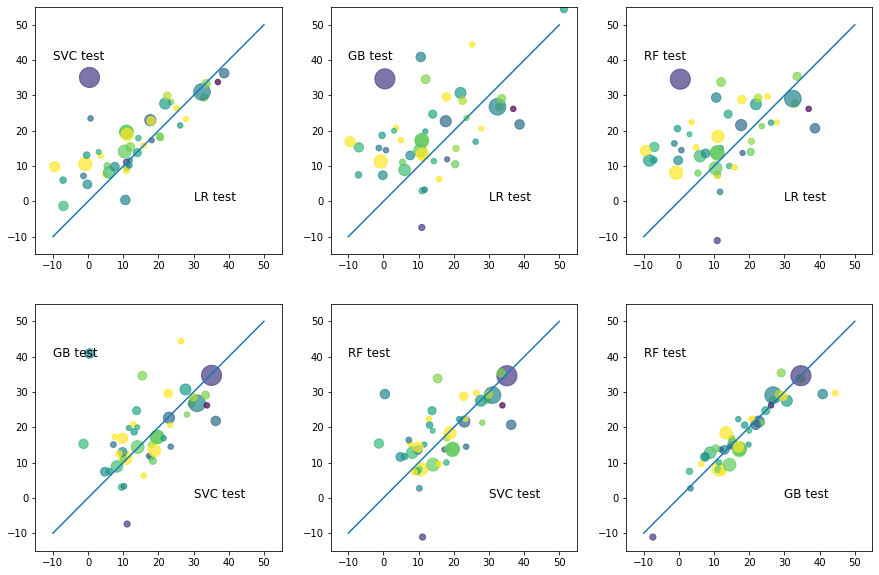

In [31]:
def compare(ax, gain1, gain2):
    ax.scatter(
        datasets_info[gain1], datasets_info[gain2], alpha=0.7,
        s=datasets_info['examples'].astype(int) ** 0.7,
        color=plt.get_cmap('viridis')(np.log(datasets_info['features'].astype(float)) / 4)
    )
    ax.plot([-10, 50], [-10, 50])
    ax.set_xlim(-15, 55)
    ax.set_ylim(-15, 55)
    ax.text(-10, 40, gain2, fontsize=12)
    ax.text(30, 0, gain1, fontsize=12)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
compare(axes.flat[0], 'LR test', 'SVC test')
compare(axes.flat[1], 'LR test', 'GB test')
compare(axes.flat[2], 'LR test', 'RF test')
compare(axes.flat[3], 'SVC test', 'GB test')
compare(axes.flat[4], 'SVC test', 'RF test')
compare(axes.flat[5], 'GB test', 'RF test')
plt.show()

In [32]:
print(len(datasets_data))
datasets_data = {x: y for x, y in datasets_data.items() if x in set(datasets_info.name)}
print(len(datasets_data))
print([X.shape for X, y in datasets_data.values()])

478
48
[(144, 78), (107, 76), (1000, 4), (116, 9), (1600, 60), (392, 11), (1728, 21), (1124, 10), (303, 27), (265, 10), (140, 13), (500, 25), (185, 2), (151, 5), (195, 22), (132, 4), (132, 24), (601, 15), (1100, 16), (500, 7), (117, 90), (151, 55), (200, 13), (403, 5), (3107, 6), (111, 3), (500, 7), (194, 107), (214, 9), (214, 9), (625, 4), (5300, 2), (100, 13), (147, 6), (1473, 21), (1728, 21), (625, 6), (950, 9), (130, 1), (145, 94), (294, 22), (195, 29), (351, 34), (398, 25), (1302, 83), (452, 279), (782, 79), (130, 9)]


In [33]:
datasets_data
datasets_info.to_csv('datasets.csv', index=False)
with open('datasets.pickle', 'wb') as f:
    pickle.dump(datasets_data, f)